In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image



In [23]:
# Set Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ViT model
model_name = "google/vit-base-patch16-224-in21k"
vit_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label={str(i): label for i, label in enumerate(['Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented', 'Non_Demented'])},
    label2id={label: i for i, label in enumerate(['Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented', 'Non_Demented'])}
)
vit_model.to(device)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [24]:
# Load pretrained EfficientNet-B2 model
efficientnet_model = models.efficientnet_b2(pretrained=True)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 4)
efficientnet_model.to(device)

# Define Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, vit, efficientnet):
        super(EnsembleModel, self).__init__()
        self.vit = vit
        self.efficientnet = efficientnet
    
    def forward(self, x):
        vit_output = self.vit(x).logits
        efficientnet_output = self.efficientnet(x)
        return (vit_output + efficientnet_output) / 2  # Average ensemble

# Initialize Ensemble Model
ensemble_model = EnsembleModel(vit_model, efficientnet_model)
ensemble_model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ensemble_model.parameters(), lr=2e-5)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 177MB/s]


In [25]:
# Training Function
def train_model(model, train_loader, valid_loader, epochs=10):
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_ensemble_model.pth")
            print("Best model saved!")



In [26]:
# Train the ensemble model
train_model(ensemble_model, train_loader, valid_loader, epochs=50)


Epoch 1/50, Loss: 0.9385, Train Acc: 0.6190
Validation Accuracy: 0.7281
Best model saved!
Epoch 2/50, Loss: 0.6396, Train Acc: 0.7275
Validation Accuracy: 0.7668
Best model saved!
Epoch 3/50, Loss: 0.5582, Train Acc: 0.7537
Validation Accuracy: 0.7915
Best model saved!
Epoch 4/50, Loss: 0.4835, Train Acc: 0.7996
Validation Accuracy: 0.8035
Best model saved!
Epoch 5/50, Loss: 0.4346, Train Acc: 0.8205
Validation Accuracy: 0.8428
Best model saved!
Epoch 6/50, Loss: 0.3982, Train Acc: 0.8397
Validation Accuracy: 0.8682
Best model saved!
Epoch 7/50, Loss: 0.3343, Train Acc: 0.8754
Validation Accuracy: 0.8409
Epoch 8/50, Loss: 0.2788, Train Acc: 0.8996
Validation Accuracy: 0.8682
Epoch 9/50, Loss: 0.2480, Train Acc: 0.9127
Validation Accuracy: 0.9335
Best model saved!
Epoch 10/50, Loss: 0.1991, Train Acc: 0.9332
Validation Accuracy: 0.9588
Best model saved!
Epoch 11/50, Loss: 0.1763, Train Acc: 0.9422
Validation Accuracy: 0.9544
Epoch 12/50, Loss: 0.1511, Train Acc: 0.9516
Validation Accura

In [34]:
import h5py

# Load the trained model weights
state_dict = torch.load("best_ensemble_model.pth", map_location=device)

# Save as .h5 file
with h5py.File("ensemble_model.h5", "w") as h5_file:
    for key, value in state_dict.items():
        h5_file.create_dataset(key, data=value.cpu().numpy())



<ipython-input-34-8455b3ba291b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_ensemble_model.pth", map_location=device)


In [37]:
import torch

# Load the best saved model
ensemble_model.load_state_dict(torch.load("best_ensemble_model.pth"))
ensemble_model.to(device)
ensemble_model.eval()

# Function to evaluate model
def evaluate_model(model, data_loader):
    correct, total, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss

# Evaluate on Train & Test Data
train_acc, train_loss = evaluate_model(ensemble_model, train_loader)
test_acc, test_loss = evaluate_model(ensemble_model, valid_loader)

# Print Final Results
print("\n=== Final Results ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


<ipython-input-37-79cf7a97120b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ensemble_model.load_state_dict(torch.load("best_ensemble_model.pth"))



=== Final Results ===
Train Accuracy: 0.9977
Train Loss: 0.0090
Test Accuracy: 0.9930
Test Loss: 0.0279


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


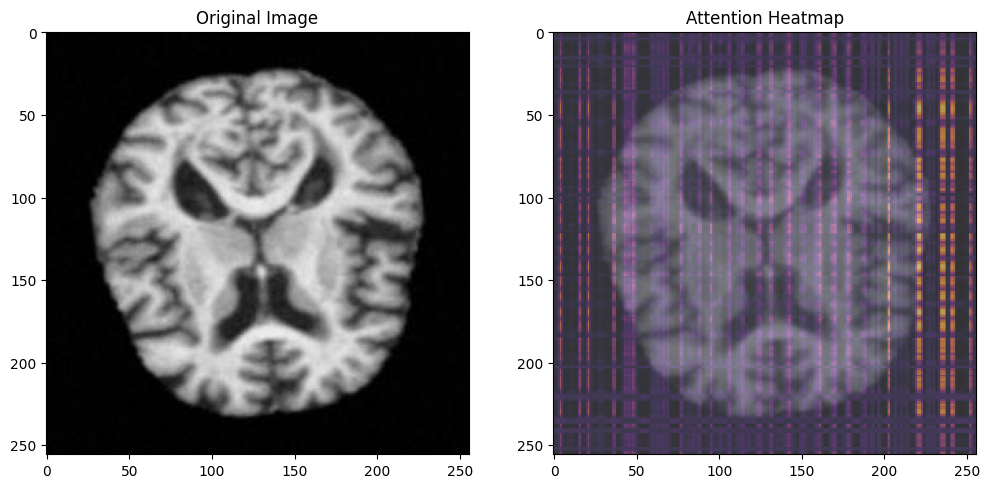

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load ViT with attention enabled
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(categories),
    id2label={str(i): label for i, label in enumerate(categories)},
    label2id={label: i for i, label in enumerate(categories)},
    output_attentions=True  # ✅ Enable attention outputs
).to(device)

def visualize_attention(model, img_path):
    model.eval()

    # ✅ Check if the file exists
    if not os.path.exists(img_path):
        print(f"⚠️ Error: File '{img_path}' not found.")
        return

    # ✅ Load image safely
    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Error: Failed to load image '{img_path}'. Check path or file corruption.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = valid_transforms(image=np.array(image))["image"]
    transformed = transformed.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed)

    if outputs.attentions is None:
        print("⚠️ Attention maps are not available. Make sure output_attentions=True.")
        return

    attentions = outputs.attentions[-1].cpu().squeeze().numpy()
    avg_attention = np.mean(attentions, axis=0)

    heatmap = cv2.resize(avg_attention, (image.shape[1], image.shape[0]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(image, alpha=0.6)
    ax[1].imshow(heatmap, cmap='inferno', alpha=0.5, interpolation='nearest')
    ax[1].set_title("Attention Heatmap")

    plt.show()

# ✅ Test on a sample image
sample_image = "/kaggle/input/dataset1/Dataset_divided/test/Mild_Demented/1002.jpg"  # Provide an actual image path
visualize_attention(model, sample_image)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🟢 Original Class: Mild_Demented
🔵 Predicted Class: Mild_Demented


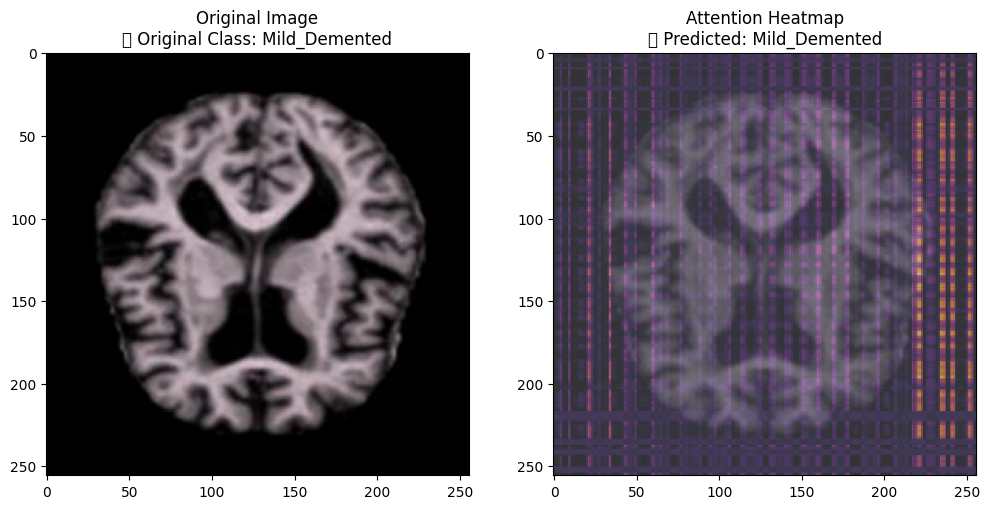

In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTForImageClassification

# ✅ Load ViT model with attention enabled
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(categories),
    id2label={str(i): label for i, label in enumerate(categories)},
    label2id={label: i for i, label in enumerate(categories)},
    output_attentions=True  # ✅ Enable attention outputs
).to(device)

def visualize_attention(model, img_path):
    model.eval()

    # ✅ Check if the file exists
    if not os.path.exists(img_path):
        print(f"⚠️ Error: File '{img_path}' not found.")
        return

    # ✅ Extract original class from the file path
    original_class = os.path.basename(os.path.dirname(img_path))  # Extracts folder name

    # ✅ Load image safely
    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Error: Failed to load image '{img_path}'. Check path or file corruption.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # ✅ Transform the image
    transformed = valid_transforms(image=np.array(image))["image"]
    transformed = transformed.unsqueeze(0).to(device)

    # ✅ Get model prediction
    with torch.no_grad():
        outputs = model(transformed)

    # ✅ Get predicted class
    predicted_idx = torch.argmax(outputs.logits, dim=1).item()
    predicted_class = model.config.id2label[str(predicted_idx)]

    # ✅ Print Original vs Predicted Class
    print(f"🟢 Original Class: {original_class}")
    print(f"🔵 Predicted Class: {predicted_class}")

    # ✅ Check if attention maps are available
    if outputs.attentions is None:
        print("⚠️ Attention maps are not available. Make sure output_attentions=True.")
        return

    # ✅ Compute attention heatmap
    attentions = outputs.attentions[-1].cpu().squeeze().numpy()
    avg_attention = np.mean(attentions, axis=0)

    heatmap = cv2.resize(avg_attention, (image.shape[1], image.shape[0]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # ✅ Plot original image and attention heatmap
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title(f"Original Image\n🟢 Original Class: {original_class}")

    ax[1].imshow(image, alpha=0.6)
    ax[1].imshow(heatmap, cmap='inferno', alpha=0.5, interpolation='nearest')
    ax[1].set_title(f"Attention Heatmap\n🔵 Predicted: {predicted_class}")

    plt.show()

# ✅ Test on a sample image
sample_image = "/kaggle/input/dataset1/Dataset_divided/test/Mild_Demented/1011.jpg"  # Update with an actual image path
visualize_attention(model, sample_image)
